In [395]:
# Import af nødvendige packages
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [396]:
""" SETTINGS """
source = 'quandl' # quandl eller csv
data_interval = 'daily' # daily, monthy eller yearly - Hvis Quandl = 'daily'
selected = ['CNP', 'F', 'WMT', 'GE', 'TSLA'] # Angiv ønskede aktiver fra Quandl eller kolonner fra CSV-ark

# Hvis CVS:
file_name = 'F-F_Research_Data_Factors.CSV' # navn og file-exstention på data

# Hvis Quandl
date_range = ['2014-1-1', '2016-12-31'] # dato fra og med - dato til og med, format YYYY-MM-DD

In [397]:
# Træk af data fra Quandl
if source == 'quandl':
    quandl.ApiConfig.api_key = "yTPaspmH6wqs9rAdSdmk"
    data = quandl.get_table('WIKI/PRICES', ticker = selected, qopts = {'columns': ['date', 'ticker', 'adj_close']},
                            date = {'gte': date_range[0], 'lte': date_range[1]}, paginate=True)
    clean = data.set_index('date')
    table = clean.pivot(columns='ticker')
    returns_data = table.pct_change()
    
# Træk af data fra CSV-fil (allerede procent-vis ændring)
elif source == 'csv':
    data = pd.read_csv(file_name, delimiter = ',', header = 0, index_col = 'date', usecols = ['date'] + selected) / 100
    returns_data = data

In [398]:
if data_interval == 'monthly':
    returns_monthly = returns_data
    returns_mean = returns_monthly.mean() * 12
    
    cov_matrix = returns_monthly.cov() * 12
    
elif data_interval == 'daily':
    returns_daily = returns_data
    returns_mean = returns_daily.mean() * 252
    
    cov_matrix = returns_daily.cov() * 252

In [399]:
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

In [400]:
num_assets = len(selected)
num_portfolios = 50000

In [401]:
# laver et seed så resultater kan reproduceres
np.random.seed(101)

# simulerer 10000 (num_portfolios) portføljer med tilfældig vægt
for single_portfolio in range(num_portfolios):
    # giver 5 (num_assets) tilfældige vægtninger mellem 0 og 1
    weights = np.random.random(num_assets)
    # normaliserer så sum af vægte = 1
    weights /= np.sum(weights)
    # udregner profit som prikprodukt af vægte og årlig profit
    returns = np.dot(weights, returns_mean)
    # udregner volatilitet
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    # udregner sharpe
    sharpe = returns / volatility

    # indsætter overstående udregninger i vektorerne
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

In [402]:
# definerer portfolier som en sammensætning af overstående
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

In [403]:
# definerer de enkelte vægte af de valgte aktiver
for i in range(len((selected))):
    symbol = selected[i]
    portfolio[symbol+' Weight'] = [Weight[i] for Weight in stock_weights]

In [404]:
# sætter vores portføljer som dataframe i pandas
df = pd.DataFrame(portfolio)
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [symbol+' Weight' for symbol in selected]
df = df[column_order]

In [405]:
# finder min vol og max sharp værdier
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

In [406]:
# finder portføljerne der stemmer overens med overstående værdier
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
minvar_portfolio = df.loc[df['Volatility'] == min_volatility]

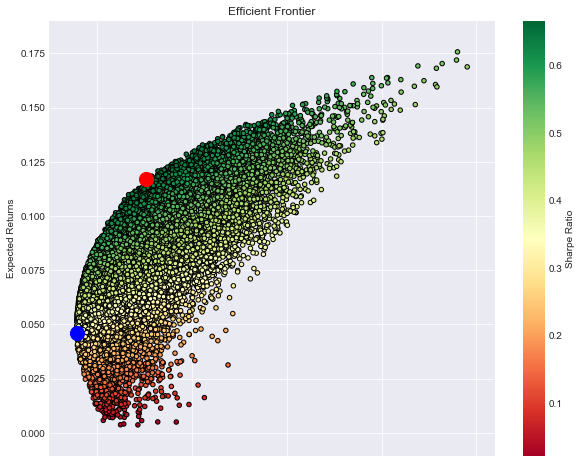

In [411]:
# plotter hele lortet
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='o', s=200)
plt.scatter(x=minvar_portfolio['Volatility'], y=minvar_portfolio['Returns'], c='blue', marker='o', s=200)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [408]:
sharpe_portfolio

,Returns,Volatility,Sharpe Ratio,CNP Weight,F Weight,WMT Weight,GE Weight,TSLA Weight
31209,0.117074,0.175743,0.666163,0.37289,0.008482,0.404987,0.21145,0.00219


In [409]:
minvar_portfolio

,Returns,Volatility,Sharpe Ratio,CNP Weight,F Weight,WMT Weight,GE Weight,TSLA Weight
17879,0.046194,0.139105,0.332081,0.240327,0.104659,0.25776,0.001487,0.395767
